In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L         

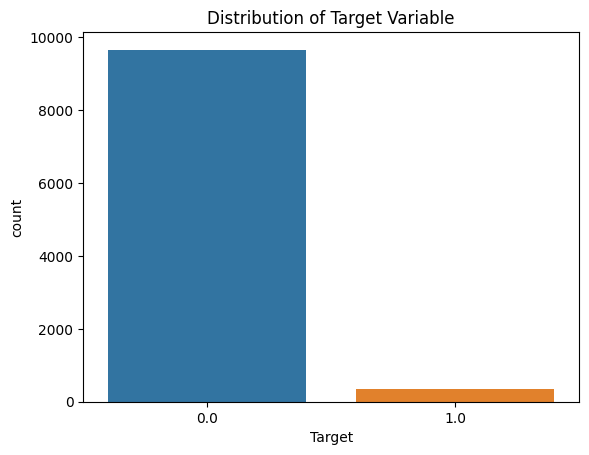

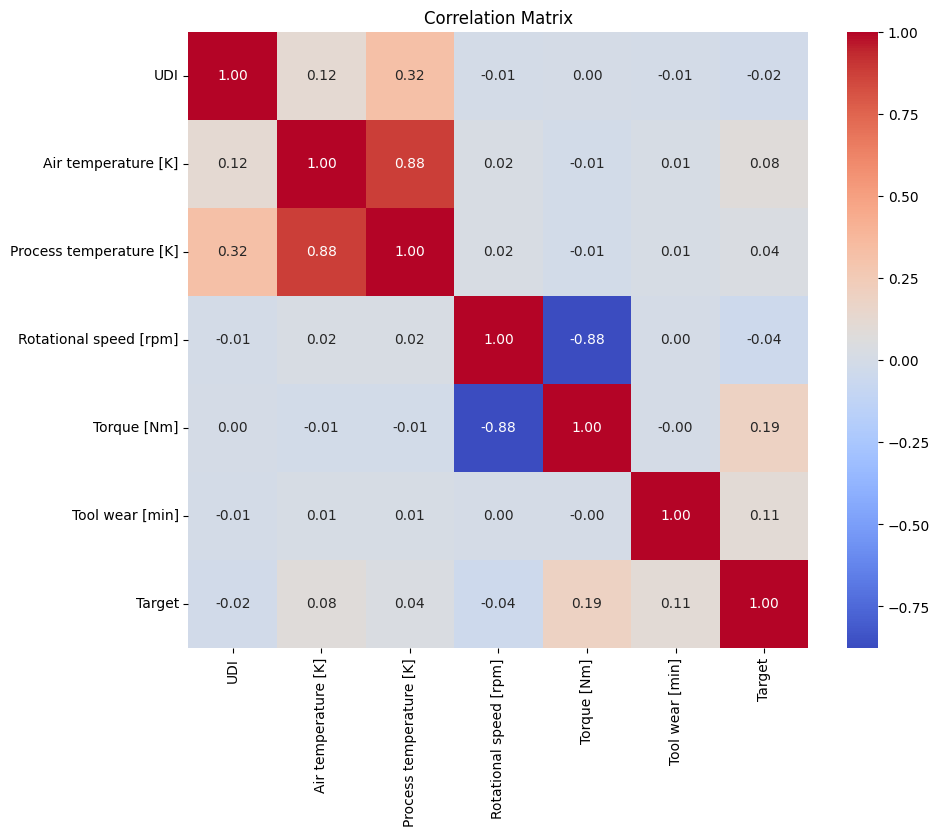

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

# Check the dataset info and first few rows
print(df.info())
print(df.head())
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

# Impute missing values for numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Check if there are still missing values
print(df.isnull().sum())
# Visualize the distribution of the target variable
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable')
plt.show()
# Filter only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Check column names
print(df.columns)


Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')


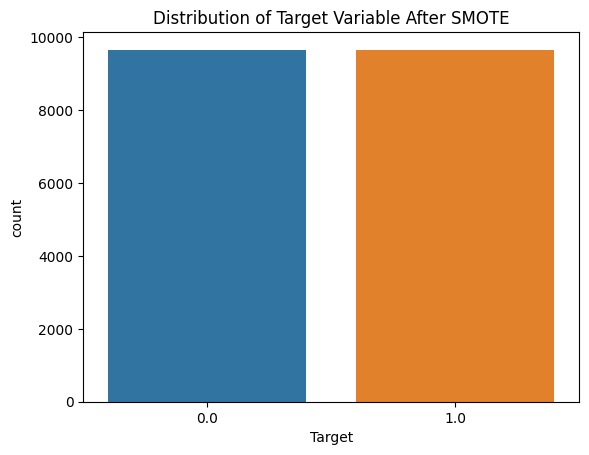

In [26]:
from imblearn.over_sampling import SMOTE

# Séparer les features et la cible
X = df.drop(columns=['Target', 'Type', 'Failure Type'])
y = df['Target']

# Appliquer SMOTE pour équilibrer le dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualiser la distribution après l'augmentation des données
sns.countplot(x=y_resampled)
plt.title('Distribution of Target Variable After SMOTE')
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convertir les données en tensors PyTorch
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled.values, dtype=torch.long)

# Créer un DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Définir l'architecture du réseau de neurones
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(X_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(y.unique()))  # La taille de la couche de sortie correspond au nombre de classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Instancier le modèle
model = DNN()
print(model)


DNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters:  {'activation': 'tanh', 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
Epoch 1/50, Train Loss: 32.8869, Train Accuracy: 0.4888, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 2/50, Train Loss: 33.0678, Train Accuracy: 0.4951, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 3/50, Train Loss: 32.4438, Train Accuracy: 0.4947, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 4/50, Train Loss: 32.8342, Train Accuracy: 0.4903, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 5/50, Train Loss: 32.6243, Train Accuracy: 0.4987, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 6/50, Train Loss: 32.9100, Train Accuracy: 0.4941, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 7/50, Train Loss: 33.8831, Train Accuracy: 0.4847, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 8/50, Train Loss: 32.2962, Train Accuracy: 0.4945, Test Loss: 7.4807, Test Accuracy: 0.4536
Epoch 9/50, Tr

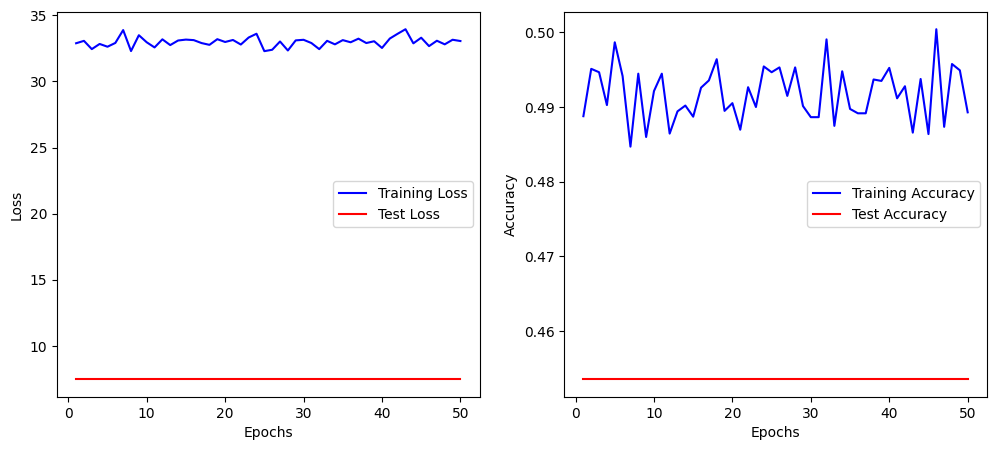

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# 1. Recherche par grille pour MLPClassifier (scikit-learn)
param_grid = {
    'hidden_layer_sizes': [(128,), (256,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [100, 200]
}

mlp = MLPClassifier()

# Grid search pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Afficher les meilleurs hyperparamètres
print("Best Hyperparameters: ", grid_search.best_params_)

# 2. Entraînement avec PyTorch

# Définir un modèle de réseau de neurones avec Dropout
class DNN_with_dropout(nn.Module):
    def __init__(self):
        super(DNN_with_dropout, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, len(y_train.unique()))  # Nombre de classes de la cible
        self.dropout = nn.Dropout(0.5)  # Dropout avec un taux de 50%

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)  # Appliquer le dropout
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Définir l'optimiseur et la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Nombre d'époques
epochs = 50

# Listes pour stocker les métriques
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convertir en Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Créer les DataLoader pour entraînement et test
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Fonction pour évaluer la précision
def accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

# Créer et entraîner le modèle
model = DNN_with_dropout()

for epoch in range(epochs):
    model.train()  # Mode entraînement
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Calcul de la perte
        loss = criterion(outputs, labels)
        
        # Backward pass et optimisation
        loss.backward()
        optimizer.step()
        
        # Accumuler la perte et la précision
        running_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

    # Calcul de la perte et précision pour cette époque
    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Évaluation sur les données de test
    model.eval()  # Mode évaluation
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        loss_test = criterion(outputs_test, y_test_tensor)
        test_loss.append(loss_test.item())
        test_accuracy.append(accuracy(y_test_tensor, outputs_test))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}")

# Tracer la perte et la précision au fil des époques
plt.figure(figsize=(12, 5))

# Tracer la perte
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, epochs+1), test_loss, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracer la précision
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracy, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Fonction pour calculer les métriques
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='macro')  # Sensitivity = Recall
    f1 = f1_score(y_true, y_pred, average='macro')  # F1 Score
    return accuracy, sensitivity, f1

# Calcul des prédictions du modèle sur les données de test
y_pred_train = model(X_train_tensor).argmax(dim=1)
y_pred_test = model(X_test_tensor).argmax(dim=1)

# Calcul des métriques pour les données d'entraînement
train_accuracy, train_sensitivity, train_f1 = calculate_metrics(y_train_tensor, y_pred_train)

# Calcul des métriques pour les données de test
test_accuracy, test_sensitivity, test_f1 = calculate_metrics(y_test_tensor, y_pred_test)

print(f"Train Metrics - Accuracy: {train_accuracy:.4f}, Sensitivity: {train_sensitivity:.4f}, F1 Score: {train_f1:.4f}")
print(f"Test Metrics - Accuracy: {test_accuracy:.4f}, Sensitivity: {test_sensitivity:.4f}, F1 Score: {test_f1:.4f}")


Train Metrics - Accuracy: 0.4560, Sensitivity: 0.4559, F1 Score: 0.3215
Test Metrics - Accuracy: 0.4536, Sensitivity: 0.4539, F1 Score: 0.3200


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Modèle avec régularisation L2 et Dropout
class DNN_with_regularization(nn.Module):
    def __init__(self, dropout_rate=0.5, weight_decay=0.01):
        super(DNN_with_regularization, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, len(y_train.unique()))  # Nombre de classes
        self.dropout = nn.Dropout(dropout_rate)  # Dropout pour la régularisation
        self.weight_decay = weight_decay  # L2 Regularization

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)  # Appliquer Dropout
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Entraînement du modèle avec Dropout et L2 Regularization
def train_model_with_regularization(dropout_rate=0.5, weight_decay=0.01, epochs=50):
    model = DNN_with_regularization(dropout_rate, weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 Regularization via weight_decay
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Diviser les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Convertir en Tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Créer les DataLoader pour entraînement et test
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Entraînement
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(correct_train / total_train)

        # Évaluation sur les données de test
        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test_tensor)
            loss_test = criterion(outputs_test, y_test_tensor)
            test_loss.append(loss_test.item())
            test_accuracy.append(accuracy_score(y_test_tensor, outputs_test.argmax(dim=1)))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}")

    return model, train_loss, train_accuracy, test_loss, test_accuracy

# Entraîner le modèle avec Dropout et L2 Regularization
model_with_reg, train_loss, train_accuracy, test_loss, test_accuracy = train_model_with_regularization(dropout_rate=0.5, weight_decay=0.01, epochs=50)

# Comparer avec un modèle sans Dropout ni L2 Regularization (vous pouvez créer un modèle sans dropout et sans weight_decay)


Epoch 1/50, Train Loss: 8.0335, Train Accuracy: 0.5877, Test Loss: 0.9664, Test Accuracy: 0.7379
Epoch 2/50, Train Loss: 1.4591, Train Accuracy: 0.6601, Test Loss: 0.5259, Test Accuracy: 0.7648
Epoch 3/50, Train Loss: 0.7547, Train Accuracy: 0.7124, Test Loss: 0.4832, Test Accuracy: 0.7560
Epoch 4/50, Train Loss: 0.7387, Train Accuracy: 0.7074, Test Loss: 0.3702, Test Accuracy: 0.8585
Epoch 5/50, Train Loss: 0.6414, Train Accuracy: 0.7345, Test Loss: 0.3976, Test Accuracy: 0.8523
Epoch 6/50, Train Loss: 0.5890, Train Accuracy: 0.7463, Test Loss: 0.5941, Test Accuracy: 0.7193
Epoch 7/50, Train Loss: 0.5938, Train Accuracy: 0.7459, Test Loss: 0.8616, Test Accuracy: 0.5043
Epoch 8/50, Train Loss: 0.5221, Train Accuracy: 0.7723, Test Loss: 0.3668, Test Accuracy: 0.8530
Epoch 9/50, Train Loss: 0.5103, Train Accuracy: 0.7741, Test Loss: 0.4302, Test Accuracy: 0.7752
Epoch 10/50, Train Loss: 0.4953, Train Accuracy: 0.7831, Test Loss: 0.3550, Test Accuracy: 0.8634
Epoch 11/50, Train Loss: 0.49